In [1]:
# ============================================================
# STEP 1: DATA PREPARATION - Discover the Pattern of Success
# ============================================================

# 1️⃣ Import library
import pandas as pd
import numpy as np

# 2️⃣ Load Excel file
excel_path = "data.xlsx"  # ganti dengan path file kamu

# Daftar sheet yang tersedia
sheets = pd.ExcelFile(excel_path).sheet_names
print("📄 Sheets ditemukan:", sheets)

📄 Sheets ditemukan: ['Talent Variable (TV) & Talent G', 'dim_companies', 'dim_areas', 'dim_positions', 'dim_departments', 'dim_divisions', 'dim_directorates', 'dim_grades', 'dim_education', 'dim_majors', 'dim_competency_pillars', 'employees', 'profiles_psych', 'papi_scores', 'strengths', 'performance_yearly', 'competencies_yearly']


In [2]:

# 3️⃣ Baca setiap sheet yang relevan
employees     = pd.read_excel(excel_path, sheet_name="employees")
performance   = pd.read_excel(excel_path, sheet_name="performance_yearly")
competencies  = pd.read_excel(excel_path, sheet_name="competencies_yearly")
pillars       = pd.read_excel(excel_path, sheet_name="dim_competency_pillars")
psych         = pd.read_excel(excel_path, sheet_name="profiles_psych")
papi          = pd.read_excel(excel_path, sheet_name="papi_scores")
strengths     = pd.read_excel(excel_path, sheet_name="strengths")

print("\n✅ Semua sheet berhasil dibaca!\n")


✅ Semua sheet berhasil dibaca!



In [3]:

# 4️⃣ Cek struktur tabel utama
for name, df_check in {
    "employees": employees,
    "performance": performance,
    "competencies": competencies,
    "profiles_psych": psych
}.items():
    print(f"📊 {name}: {df_check.shape[0]} baris, {df_check.shape[1]} kolom")
    print(df_check.head(2), "\n")


📊 employees: 2010 baris, 13 kolom
  employee_id        fullname     nip  company_id  area_id  position_id  \
0   EMP100000  Rendra Pratama  806137           1        4            1   
1   EMP100001  Wulan Setiawan  476388           4        4            4   

   department_id  division_id  directorate_id  grade_id  education_id  \
0              6            3               3         2             3   
1              5            5               3         1             1   

   major_id  years_of_service_months  
0         1                       64  
1         2                       16   

📊 performance: 10050 baris, 3 kolom
  employee_id  rating  year
0   EMP100000     2.0  2021
1   EMP100001     NaN  2021 

📊 competencies: 100500 baris, 4 kolom
  employee_id  score pillar_code  year
0   EMP100000    2.0         GDR  2021
1   EMP100001    NaN         GDR  2021 

📊 profiles_psych: 2010 baris, 9 kolom
  employee_id  pauli  faxtor disc              disc_word  mbti    iq   gtq  \
0   EM

In [4]:

# 5️⃣ Periksa konsistensi employee_id
print("Jumlah unique employee_id:")
for name, df_check in {
    "employees": employees,
    "performance": performance,
    "competencies": competencies,
    "profiles_psych": psych
}.items():
    print(f" - {name}: {df_check['employee_id'].nunique()} unik ID")

# --- rename kolom year agar tidak bentrok
competencies.rename(columns={'year': 'year_competency'}, inplace=True)

# --- agregasi rata-rata skor kompetensi per karyawan per tahun
competency_avg = (
    competencies.groupby(["employee_id", "year_competency"])["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "avg_competency_score"})
)

Jumlah unique employee_id:
 - employees: 2010 unik ID
 - performance: 2010 unik ID
 - competencies: 2010 unik ID
 - profiles_psych: 2010 unik ID


In [5]:

# 6️⃣ Gabungkan data antar tabel
# Join urutan: performance → employees → psych → competency_avg
df = performance.merge(employees, on="employee_id", how="left")
df = df.merge(psych, on="employee_id", how="left")
df = df.merge(
    competency_avg,
    left_on=["employee_id", "year"],
    right_on=["employee_id", "year_competency"],
    how="left"
)
# merge tambahan ke pillars hanya bila dibutuhkan nanti (per pilar)
print("\n✅ Data berhasil digabung tanpa duplikasi!")
print("Ukuran dataset gabungan:", df.shape)
print(df.head(3))


✅ Data berhasil digabung tanpa duplikasi!
Ukuran dataset gabungan: (10050, 25)
  employee_id  rating  year                  fullname     nip  company_id  \
0   EMP100000     2.0  2021            Rendra Pratama  806137           1   
1   EMP100001     NaN  2021            Wulan Setiawan  476388           4   
2   EMP100002     2.0  2021  Julia Jatmiko Situmorang  941921           1   

   area_id  position_id  department_id  division_id  ...  pauli  faxtor  disc  \
0        4            1              6            3  ...     86      75    SI   
1        4            4              5            5  ...     48      52    DS   
2        3            5              1            1  ...     66      38    DC   

                disc_word  mbti     iq   gtq tiki year_competency  \
0   Steadiness-Influencer   NaN   94.0  33.0    2            2021   
1     Dominant-Steadiness  INTP   94.0  17.0    3            2021   
2  Dominant-Conscientious   NaN  109.0  20.0    3            2021   

  avg_com

In [6]:

# 7️⃣ Cek missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_summary / len(df) * 100).round(2)
missing_report = pd.DataFrame({
    "missing_count": missing_summary,
    "missing_%": missing_pct
})
print("\n📋 Missing Value Report (10 kolom teratas):")
print(missing_report.head(10))


📋 Missing Value Report (10 kolom teratas):
                      missing_count  missing_%
iq                             2280      22.69
gtq                            1660      16.52
rating                         1108      11.02
disc                            855       8.51
mbti                            745       7.41
avg_competency_score            291       2.90
major_id                          0       0.00
year_competency                   0       0.00
tiki                              0       0.00
disc_word                         0       0.00


In [7]:
# 8️⃣ Normalisasi kolom teks
text_cols = ["fullname", "mbti", "disc", "first_word", "second_word"]
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.upper()

# 9️⃣ Bersihkan nilai IQ / numeric (outlier)
if "iq" in df.columns:
    q_low, q_high = df["iq"].quantile([0.01, 0.99])
    df.loc[(df["iq"] < q_low) | (df["iq"] > q_high), "iq"] = np.nan

# 🔟 Cek dan hapus duplikasi
before = len(df)
df.drop_duplicates(subset=["employee_id", "year"], inplace=True)
after = len(df)
print(f"\n🧹 Hapus duplikat: {before - after} baris ganda dihapus")

# 1️⃣1️⃣ Simpan hasil gabungan
output_path = "combined_employee_data.csv"
df.to_csv(output_path, index=False)
print(f"\n💾 File gabungan berhasil disimpan ke: {output_path}")


🧹 Hapus duplikat: 0 baris ganda dihapus

💾 File gabungan berhasil disimpan ke: combined_employee_data.csv


In [8]:

# 1️⃣2️⃣ Ringkasan akhir
print("\n=== SUMMARY REPORT ===")
print("Total baris :", len(df))
print("Karyawan unik :", df['employee_id'].nunique())

if 'year' in df.columns:
    print("Tahun unik :", df['year'].unique())

print("Rating unik :", sorted(df['rating'].dropna().unique()))
print("\nKolom tersedia:", list(df.columns))
print("\n✅ STEP 1 SELESAI — Data siap untuk EDA (STEP 2)")



=== SUMMARY REPORT ===
Total baris : 10050
Karyawan unik : 2010
Tahun unik : [2021 2022 2023 2024 2025]
Rating unik : [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 99.0]

Kolom tersedia: ['employee_id', 'rating', 'year', 'fullname', 'nip', 'company_id', 'area_id', 'position_id', 'department_id', 'division_id', 'directorate_id', 'grade_id', 'education_id', 'major_id', 'years_of_service_months', 'pauli', 'faxtor', 'disc', 'disc_word', 'mbti', 'iq', 'gtq', 'tiki', 'year_competency', 'avg_competency_score']

✅ STEP 1 SELESAI — Data siap untuk EDA (STEP 2)


In [9]:
analis = pd.read_csv("combined_employee_data.csv")

In [10]:
analis

,employee_id,rating,year,fullname,nip,company_id,area_id,position_id,department_id,division_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,year_competency,avg_competency_score
0,EMP100000,2.0,2021,RENDRA PRATAMA,806137,1,4,1,6,3,...,86,75,SI,Steadiness-Influencer,NAN,94.0,33.0,2,2021,1.700000
1,EMP100001,NaN,2021,WULAN SETIAWAN,476388,4,4,4,5,5,...,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3,2021,NaN
2,EMP100002,2.0,2021,JULIA JATMIKO SITUMORANG,941921,1,3,5,1,1,...,66,38,DC,Dominant-Conscientious,NAN,109.0,20.0,3,2021,1.888889
3,EMP100003,NaN,2021,OKA HALIM,751615,1,3,4,2,1,...,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3,2021,NaN
4,EMP100004,3.0,2021,DWI PRATAMA,443809,3,4,6,5,3,...,75,100,NAN,Steadiness-Conscientious,INTJ,134.0,21.0,9,2021,2.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045,DUP1942,5.0,2025,DEWI FADILLAH HIDAYAT,325441,4,4,1,4,1,...,55,54,CD,Conscientious-Dominant,ISFP,NaN,NaN,8,2025,4.888889
10046,DUP2096,3.0,2025,PUTRI WIBOWO,149080,3,3,4,4,2,...,27,62,SD,Steadiness-Dominant,ISFJ,NaN,NaN,4,2025,2.900000
10047,DUP4177,2.0,2025,ADI GINTING,116115,4,2,6,4,4,...,41,22,DS,Dominant-Steadiness,ENTJ,NaN,NaN,8,2025,1.900000
10048,DUP9801,5.0,2025,AYU KUSUMA SANTOSO,889823,2,3,3,3,1,...,37,64,SC,Steadiness-Conscientious,ISTJ,131.0,28.0,7,2025,4.800000


In [11]:
analis.head()

,employee_id,rating,year,fullname,nip,company_id,area_id,position_id,department_id,division_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,year_competency,avg_competency_score
0,EMP100000,2.0,2021,RENDRA PRATAMA,806137,1,4,1,6,3,...,86,75,SI,Steadiness-Influencer,NAN,94.0,33.0,2,2021,1.700000
1,EMP100001,NaN,2021,WULAN SETIAWAN,476388,4,4,4,5,5,...,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3,2021,NaN
2,EMP100002,2.0,2021,JULIA JATMIKO SITUMORANG,941921,1,3,5,1,1,...,66,38,DC,Dominant-Conscientious,NAN,109.0,20.0,3,2021,1.888889
3,EMP100003,NaN,2021,OKA HALIM,751615,1,3,4,2,1,...,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3,2021,NaN
4,EMP100004,3.0,2021,DWI PRATAMA,443809,3,4,6,5,3,...,75,100,NAN,Steadiness-Conscientious,INTJ,134.0,21.0,9,2021,2.800000


In [12]:
analis.tail()

,employee_id,rating,year,fullname,nip,company_id,area_id,position_id,department_id,division_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,year_competency,avg_competency_score
10045,DUP1942,5.0,2025,DEWI FADILLAH HIDAYAT,325441,4,4,1,4,1,...,55,54,CD,Conscientious-Dominant,ISFP,NaN,NaN,8,2025,4.888889
10046,DUP2096,3.0,2025,PUTRI WIBOWO,149080,3,3,4,4,2,...,27,62,SD,Steadiness-Dominant,ISFJ,NaN,NaN,4,2025,2.900000
10047,DUP4177,2.0,2025,ADI GINTING,116115,4,2,6,4,4,...,41,22,DS,Dominant-Steadiness,ENTJ,NaN,NaN,8,2025,1.900000
10048,DUP9801,5.0,2025,AYU KUSUMA SANTOSO,889823,2,3,3,3,1,...,37,64,SC,Steadiness-Conscientious,ISTJ,131.0,28.0,7,2025,4.800000
10049,DUP3452,3.0,2025,FITRI ANUGRAH SUBEKTI,890632,1,4,3,3,5,...,60,65,ID,Influencer-Dominant,ESFJ,90.0,38.0,7,2025,3.100000


In [13]:
analis.describe()

,rating,year,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,education_id,major_id,years_of_service_months,pauli,faxtor,iq,gtq,tiki,year_competency,avg_competency_score
count,8942.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,10050.000000,7770.000000,8390.000000,10050.000000,10050.000000,9759.000000
mean,3.217289,2023.000000,550175.979104,2.498010,2.468159,3.502985,3.527363,3.032836,2.034826,1.997512,2.464677,3.519900,50.124378,59.974129,60.283085,109.513514,27.464839,5.481095,2023.000000,3.352520
std,2.887923,1.414284,259281.065710,1.108703,1.132671,1.682371,1.680079,1.408967,0.814573,0.818663,1.106794,1.687277,25.176567,23.424021,22.928236,17.891965,6.285297,2.894278,1.414284,2.918023
min,0.000000,2021.000000,100945.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,20.000000,20.000000,80.000000,9.000000,1.000000,2021.000000,0.000000
25%,2.000000,2022.000000,325705.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,32.000000,39.000000,41.000000,94.000000,23.000000,3.000000,2022.000000,2.436508
50%,3.000000,2023.000000,540371.000000,2.000000,2.000000,4.000000,4.000000,3.000000,2.000000,2.000000,2.000000,3.000000,50.000000,60.000000,62.000000,109.000000,27.000000,6.000000,2023.000000,3.100000
75%,4.000000,2024.000000,776343.000000,3.000000,3.000000,5.000000,5.000000,4.000000,3.000000,3.000000,3.000000,5.000000,66.000000,80.000000,80.000000,125.000000,32.000000,8.000000,2024.000000,4.000000
max,99.000000,2025.000000,999361.000000,4.000000,4.000000,6.000000,6.000000,5.000000,3.000000,3.000000,4.000000,6.000000,149.000000,100.000000,100.000000,140.000000,46.000000,10.000000,2025.000000,99.000000


In [14]:
analis.columns

Index(['employee_id', 'rating', 'year', 'fullname', 'nip', 'company_id',
       'area_id', 'position_id', 'department_id', 'division_id',
       'directorate_id', 'grade_id', 'education_id', 'major_id',
       'years_of_service_months', 'pauli', 'faxtor', 'disc', 'disc_word',
       'mbti', 'iq', 'gtq', 'tiki', 'year_competency', 'avg_competency_score'],
      dtype='object')

In [15]:
#menghitung persentase nilai yang hilang (missing values)
analis.isna().sum()/len(analis)*100

employee_id                 0.000000
rating                     11.024876
year                        0.000000
fullname                    0.000000
nip                         0.000000
company_id                  0.000000
area_id                     0.000000
position_id                 0.000000
department_id               0.000000
division_id                 0.000000
directorate_id              0.000000
grade_id                    0.000000
education_id                0.000000
major_id                    0.000000
years_of_service_months     0.000000
pauli                       0.000000
faxtor                      0.000000
disc                        0.000000
disc_word                   0.000000
mbti                        0.000000
iq                         22.686567
gtq                        16.517413
tiki                        0.000000
year_competency             0.000000
avg_competency_score        2.895522
dtype: float64

In [16]:
print(analis.info())
print(analis.describe())
print(analis['rating'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              10050 non-null  object 
 1   rating                   8942 non-null   float64
 2   year                     10050 non-null  int64  
 3   fullname                 10050 non-null  object 
 4   nip                      10050 non-null  int64  
 5   company_id               10050 non-null  int64  
 6   area_id                  10050 non-null  int64  
 7   position_id              10050 non-null  int64  
 8   department_id            10050 non-null  int64  
 9   division_id              10050 non-null  int64  
 10  directorate_id           10050 non-null  int64  
 11  grade_id                 10050 non-null  int64  
 12  education_id             10050 non-null  int64  
 13  major_id                 10050 non-null  int64  
 14  years_of_service_month

In [17]:
high_perf =    analis[analis['rating'] == 5]
others =   analis[analis['rating'] < 5]


In [18]:
num_cols = ['avg_competency_score', 'iq', 'years_of_service_months']
analis[num_cols + ['rating']].groupby('rating').mean().round(2)


,avg_competency_score,iq,years_of_service_months
rating,,,
0.0,3.13,107.15,42.47
1.0,1.46,110.06,51.07
2.0,2.14,109.37,50.25
3.0,3.14,109.56,51.64
4.0,4.17,108.88,51.42
5.0,4.83,108.83,51.37
6.0,2.51,104.00,53.00
99.0,3.38,118.40,64.14


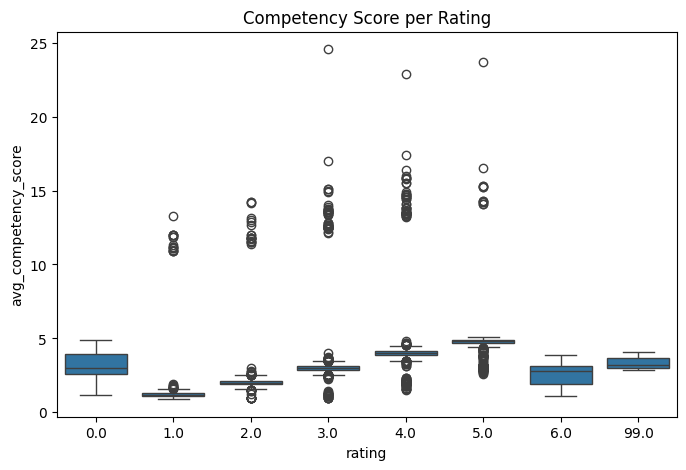

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='rating', y='avg_competency_score')
plt.title("Competency Score per Rating")
plt.show()


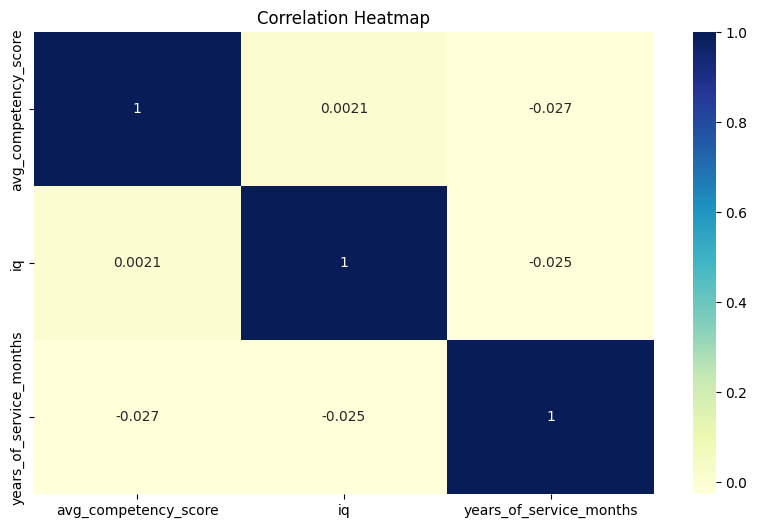

In [20]:
plt.figure(figsize=(10,6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()


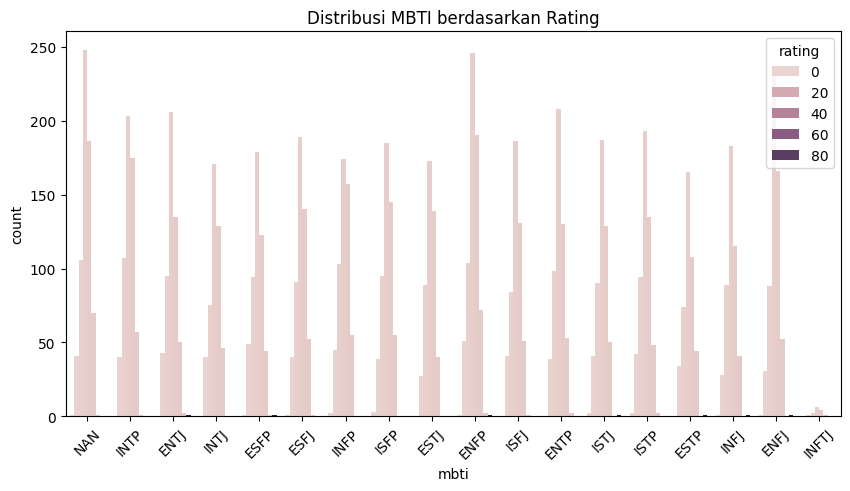

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='mbti', hue='rating')
plt.title("Distribusi MBTI berdasarkan Rating")
plt.xticks(rotation=45)
plt.show()


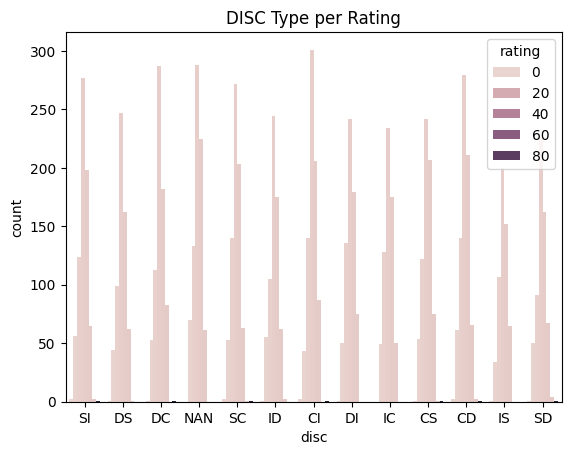

In [22]:
sns.countplot(data=df, x='disc', hue='rating')
plt.title("DISC Type per Rating")
plt.show()


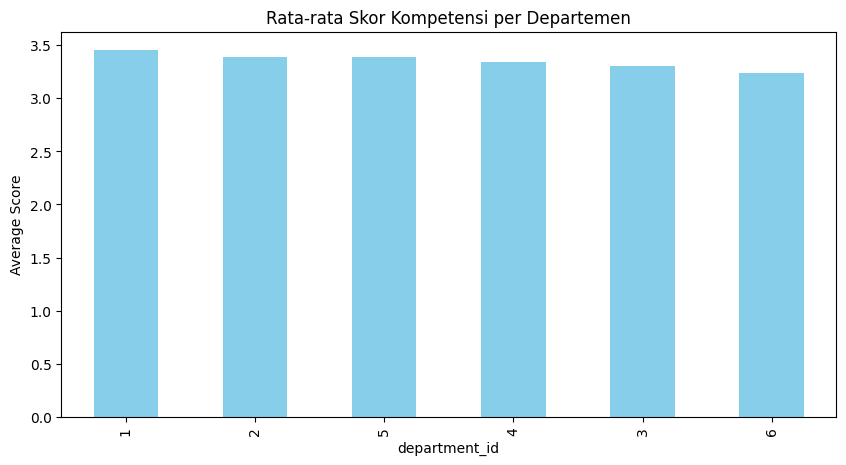

In [23]:
pillar_summary = (
    analis.groupby('department_id')['avg_competency_score']
      .mean()
      .sort_values(ascending=False)
)

pillar_summary.plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title("Rata-rata Skor Kompetensi per Departemen")
plt.ylabel("Average Score")
plt.show()


In [24]:
SuccessScore = (
    0.35 * analis['avg_competency_score'].fillna(0) +
    0.25 * analis['iq'].fillna(0) +
    0.15 * analis['years_of_service_months'].fillna(0)
)
analis['SuccessScore'] = SuccessScore



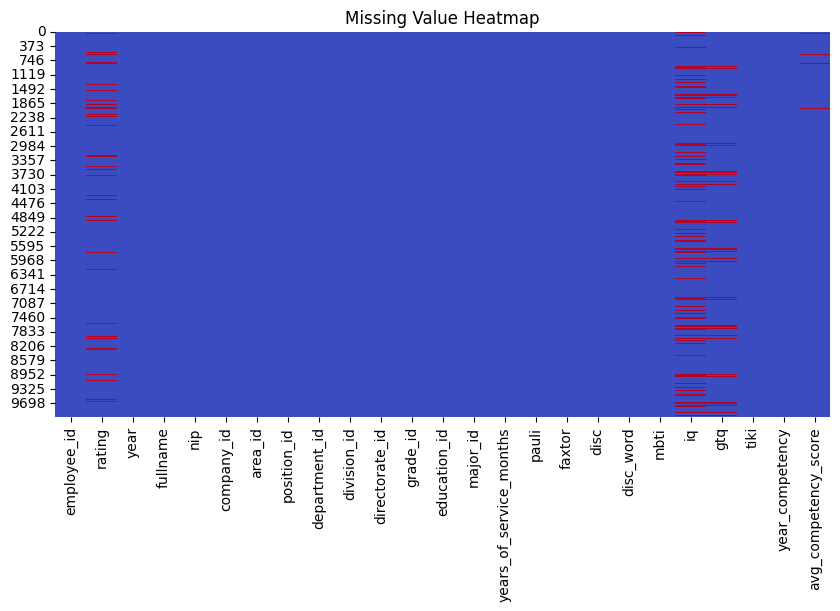

In [25]:

# --- Missing Value Heatmap ---
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='coolwarm')
plt.title("Missing Value Heatmap")
plt.show()


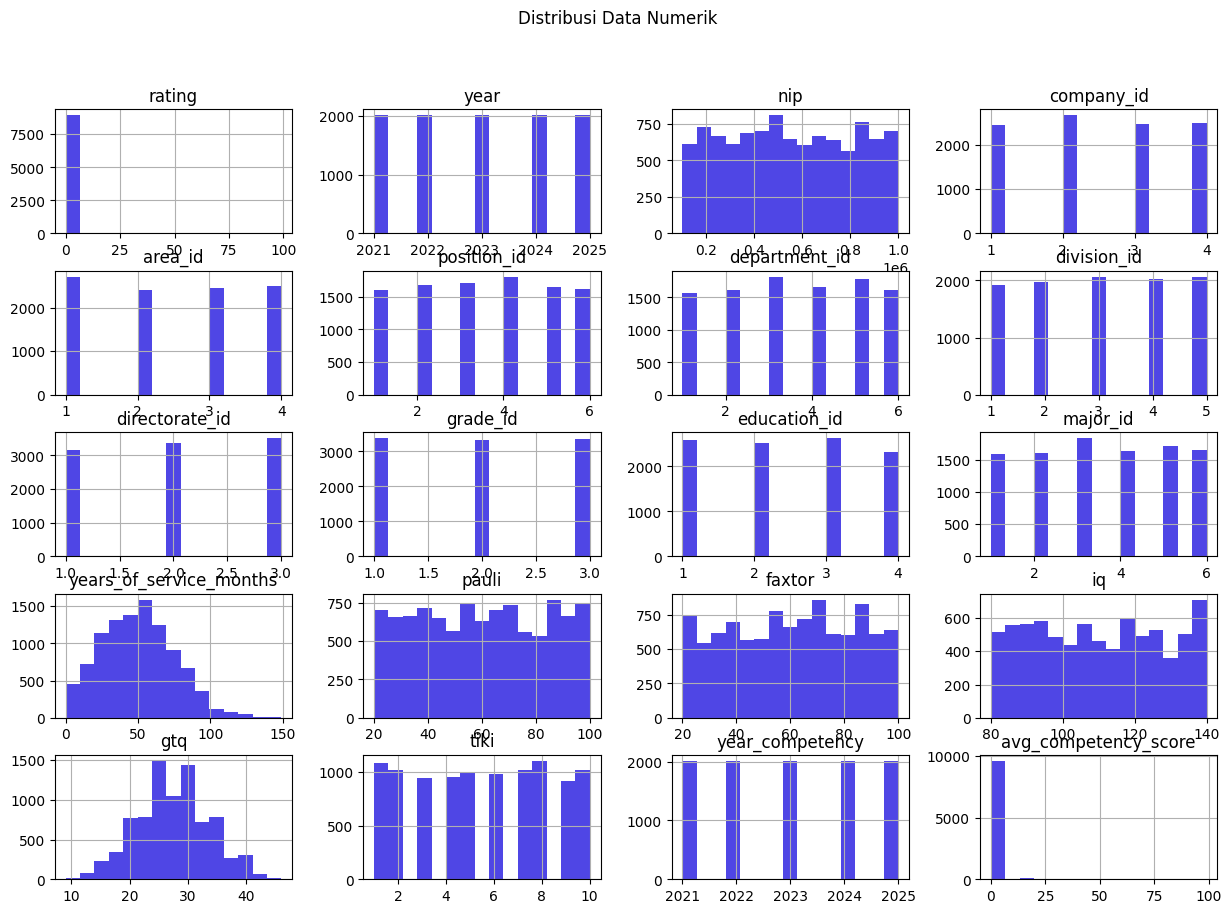

In [26]:

# --- Distribusi Kolom Numerik ---
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    df[numeric_cols].hist(bins=15, figsize=(15, 10), color='#4F46E5')
    plt.suptitle("Distribusi Data Numerik")
    plt.show()

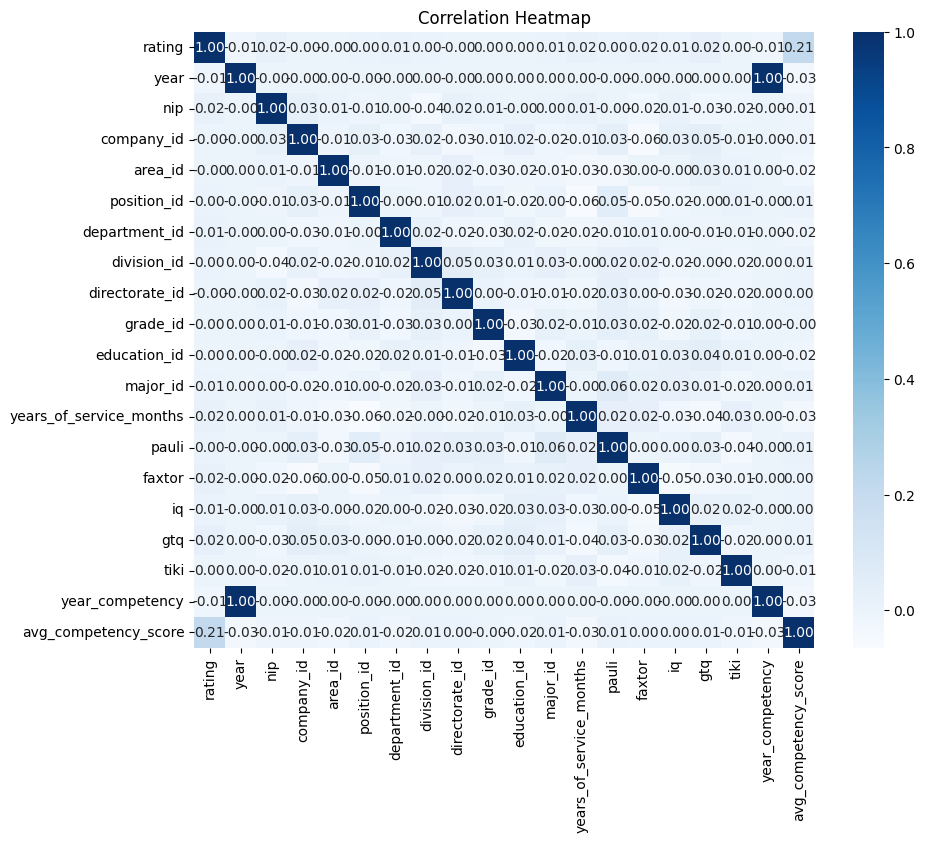

In [27]:
# --- Korelasi antar variabel numerik ---
if len(numeric_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='Blues', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()


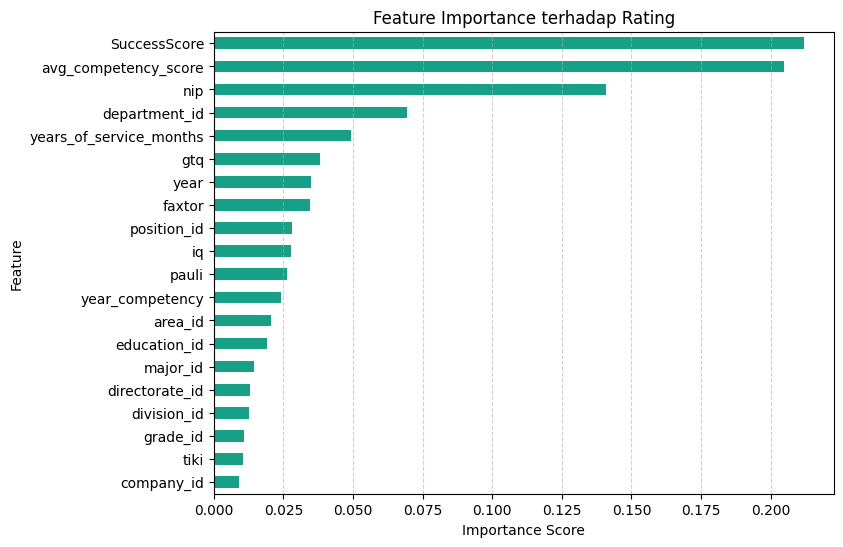


🌟 Top 5 Fitur Paling Berpengaruh terhadap Rating:


SuccessScore               0.212041
avg_competency_score       0.204618
nip                        0.140771
department_id              0.069320
years_of_service_months    0.049298
dtype: float64

In [28]:
# ============================================================
# 🧩 2. FEATURE IMPORTANCE ANALYSIS (Versi Aman + Lengkap)
# ============================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Pastikan ada kolom "rating"
if "rating" in analis.columns:
    # Pisahkan fitur numerik & target
    X = analis.select_dtypes(include=[np.number]).drop(columns=["rating"], errors="ignore")
    y = analis["rating"]

    # Bersihkan missing values
    df_model = pd.concat([X, y], axis=1).dropna(subset=["rating"])  # hapus baris dengan rating kosong
    X = df_model.drop(columns=["rating"])
    y = df_model["rating"]

    # Imputasi NaN di fitur numerik
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    if not X_imputed.empty:
        model = RandomForestRegressor(random_state=42)
        model.fit(X_imputed, y)

        importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)

        # 🔍 Visualisasi
        plt.figure(figsize=(8, 6))
        importance.plot(kind='barh', color='#16a085')
        plt.title("Feature Importance terhadap Rating")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.grid(axis="x", linestyle="--", alpha=0.6)
        plt.show()

        # 🔎 Tampilkan fitur paling penting
        top_features = importance.sort_values(ascending=False).head(5)
        print("\n🌟 Top 5 Fitur Paling Berpengaruh terhadap Rating:")
        display(top_features)
    else:
        print("⚠️ Tidak ada fitur numerik yang valid untuk dihitung importance-nya.")
else:
    print("❌ Kolom 'rating' tidak ditemukan dalam dataset.")


In [29]:
# ============================================================
# 📉 4. DATA QUALITY REPORT
# ============================================================
def data_quality_report(df):
    total_rows = len(df)
    missing = df.isnull().sum()
    missing_pct = (missing / total_rows * 100).round(2)
    dtypes = df.dtypes
    quality_df = pd.DataFrame({"Data Type": dtypes, "Missing Values": missing, "Missing %": missing_pct})
    display(quality_df.sort_values("Missing %", ascending=False))

    score = 100 - missing_pct.mean()
    print(f"\n📋 Data Quality Score: {score:.2f}/100")

data_quality_report(df)


,Data Type,Missing Values,Missing %
iq,float64,2280,22.69
gtq,float64,1660,16.52
rating,float64,1108,11.02
avg_competency_score,float64,291,2.90
major_id,int64,0,0.00
year_competency,int64,0,0.00
tiki,int64,0,0.00
mbti,object,0,0.00
disc_word,object,0,0.00
disc,object,0,0.00



📋 Data Quality Score: 97.87/100
